# Final version of the classifiers and meta classifier script


### Parameter settings

First, parameters are set. The parameters are obtained from a crossvalidation performed for each seperate classifier. 

In [1]:
# Attributes from dataset that we use for classification
# selected during crossvalidation

nAttributes = ['popularity resquer id',
 'Age',
 'Breed1',
 'img_pixels',
 'description length',
 'PhotoAmt',
 'img_ave_contrast',
 'Sterilized',
 'sentiment',
 'Breed2',
 'img_metadata_sentiment2',
 'FurLength',
 'Quantity',
 'State',
 'Dewormed',
 'Color1',
 'MaturitySize',
 'Fee',
 'mix',
 'vaccin',
 'Vaccinated',
 'Color3',
 'cute']

max_depth = 8  #max depth of decision tree
n_estimators = 10  # number of trees in random forest
tol = 0.01  #tolerance in (gradient/line) search in Support Vector Machine classifier, Logistic Regression
nn = 15  # number of neighbors for K-Nearest Neighbor classifier
xgb_params = {  #parameters for XGBoost
    'eval_metric': 'rmse',
    'seed': 1337,
    'verbosity': 0,
}   

### Some additional pre-processing

Data is loaded and relevant attributes are obtained. A gaussian transform and normalisation transform is applied to the appropriate variables. Dataset is also converted with dummy variables for categorical attributes so that Logistic Regression can be performed. 

### Meta train/test set

The train data is divided into a meta train and meta test set, to train and test the meta classifier respectively. 10% of the train data is used for meta testing, which helps select the best model for meta classifying.  

In [2]:
import pandas as pd
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn import model_selection
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import PowerTransformer
from sklearn import preprocessing



data = pd.read_csv('Data/preprocessedTrain3.csv') #import data
X = data.loc[:, data.columns != 'AdoptionSpeed'] #create X without labels
X = X.fillna(0)
X = X.drop('Description',axis=1) #drop non numerical values
X = X.drop('PetID',axis=1) #
X = X.drop('RescuerID',axis=1)
X = X.drop('Unnamed: 0',axis=1)
X = X.drop('Unnamed: 0.1',axis=1)
X = X.drop('img_metadata_label',axis=1)
X = X[nAttributes]
y = data['AdoptionSpeed'] #label vector

test = pd.read_csv('Data/preprocessedtest3.csv')


X_test = test.drop('Description',axis=1) #drop non numerical values
X_test = X_test.fillna(0)
id = X_test['PetID']
X_test = X_test.drop('PetID',axis=1) #
X_test = X_test.drop('RescuerID',axis=1)
X_test = X_test.drop('Unnamed: 0',axis=1)
X_test = X_test.drop('Unnamed: 0.1',axis=1)

X_test = X_test.drop('img_metadata_label',axis=1)
X_test = X_test[nAttributes]


non_zer0 = np.mean(X==0)==0
zero = non_zer0[non_zer0.values==False].index
non_zer0 = non_zer0[non_zer0.values==True].index

scaler = preprocessing.PowerTransformer(method='box-cox', standardize=True).fit(X[non_zer0])
X[non_zer0] = scaler.transform(X[non_zer0])
X_test[non_zer0] = scaler.transform(X_test[non_zer0])
scaler = preprocessing.StandardScaler().fit(X[zero])
X[zero] = scaler.transform(X[zero])
X_test[zero] = scaler.transform(X_test[zero])

meta_train, meta_test, meta_y_train, meta_y_test = model_selection.train_test_split(X,y,test_size=0.5,stratify=y)



Xlr_train = meta_train
Xlr_m_test = meta_test
Xlr_test = X_test
dummy = ['State','Type','Breed1','Breed2','Gender','Color1','Color2','Color3','Vaccinated','Dewormed','Sterilized']
for d in dummy:
    if(d in nAttributes):
        
        train = pd.get_dummies(Xlr_train[d],prefix=d)
        test = pd.get_dummies(Xlr_test[d],prefix=d)
        m_test = pd.get_dummies(Xlr_m_test[d],prefix=d)
        result = set(list(train))
        result.intersection_update(list(test))
        result.intersection_update(list(m_test))
        one_hottr = train[list(result)]
        one_hot = test[list(result)]
        one_hotm = m_test[list(result)]
        Xlr_train = Xlr_train.drop(d,axis = 1)
        # Join the encoded df
        Xlr_train = Xlr_train.join(one_hottr)
        
        Xlr_test = Xlr_test.drop(d,axis = 1)
        Xlr_test = Xlr_test.join(one_hot)
        Xlr_m_test = Xlr_m_test.drop(d,axis=1)
        Xlr_m_test = Xlr_m_test.join(one_hotm)

C:\Users\Lisa\Anaconda3\lib\site-packages\scipy\stats\morestats.py:902: RuntimeWarning: divide by zero encountered in log
  llf -= N / 2.0 * np.log(np.sum((y - y_mean)**2. / N, axis=0))
C:\Users\Lisa\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Lisa\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
C:\Users\Lisa\Anaconda3\lib\site-packages\ipykernel_launcher.py:56: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


## Classifiers

The following classifiers were trained on the meta train data:

+ Decision Tree classifier
+ Random Forest classifier
+ Logistic Regression
+ Support Vector Machine classifier
+ K-nearest Neighbor classifier
+ Naive Bayes classifier
+ XG Boost


The predictions from these classifiers on the train data, the meta test data and the actual test data are obtained. 

In [3]:
classifiers = 'DTC RF LOGREG KNN SVM SVMlinear GNB XGB ADABoost QDA'.split(sep=' ')
predictions = np.zeros((len(X_test),len(classifiers)))
mlp_train = np.zeros((len(meta_train),len(classifiers)))
mlp_test = np.zeros((len(meta_test),len(classifiers)))

dtc = tree.DecisionTreeClassifier(criterion='gini',max_depth=max_depth) #train decision tree
dtc = dtc.fit(meta_train,meta_y_train)
predictions[:,0] = dtc.predict(X_test)
mlp_train[:,0] = dtc.predict(meta_train)
mlp_test[:,0] = dtc.predict(meta_test)

rf = RandomForestRegressor(n_estimators = n_estimators)
rf = rf.fit(meta_train, meta_y_train)
predictions[:,1] = np.round(rf.predict(X_test),0)
mlp_train[:,1] = np.round(rf.predict(meta_train),0)
mlp_test[:,1] = np.round(rf.predict(meta_test),0)

logreg = LogisticRegression(tol=tol,solver='liblinear',multi_class='auto')
logreg = logreg.fit(Xlr_train, meta_y_train)
predictions[:,2] = logreg.predict(Xlr_test)
mlp_train[:,2] = logreg.predict(Xlr_train)
mlp_test[:,2] = logreg.predict(Xlr_m_test)

knn = KNeighborsClassifier(nn)
knn = knn.fit(meta_train, meta_y_train)
predictions[:,3] = knn.predict(X_test)
mlp_train[:,3] = knn.predict(meta_train)
mlp_test[:,3] = knn.predict(meta_test)

svm = SVC(tol=tol,gamma='auto')
svm = svm.fit(meta_train, meta_y_train)
predictions[:,4] = svm.predict(X_test)
mlp_train[:,4] = svm.predict(meta_train)
mlp_test[:,4] = svm.predict(meta_test)

svml = SVC(kernel="linear", C=0.025)
svml = svml.fit(meta_train,meta_y_train)
predictions[:,5] = svml.predict(X_test)
mlp_train[:,5] = svml.predict(meta_train)
mlp_test[:,5] = svml.predict(meta_test)

gnb = GaussianNB()
gnb = gnb.fit(meta_train, meta_y_train)
predictions[:,6] = gnb.predict(X_test)
mlp_train[:,6] = gnb.predict(meta_train)
mlp_test[:,6] = gnb.predict(meta_test)

d_train = xgb.DMatrix(data=meta_train, label=meta_y_train, feature_names=meta_train.columns)
d_val = xgb.DMatrix(data=meta_test,label=meta_y_test, feature_names=meta_test.columns)
evallist = [(d_val, 'eval'), (d_train, 'train')]
model = xgb.train(dtrain=d_train, num_boost_round=30000, evals=evallist, early_stopping_rounds=3000, verbose_eval=30000, params=xgb_params)
predictions[:,7] = np.round(model.predict(xgb.DMatrix(X_test, feature_names=X_test.columns), ntree_limit=model.best_ntree_limit),0)
mlp_train[:,7] = np.round(model.predict(xgb.DMatrix(meta_train, feature_names=meta_train.columns), ntree_limit=model.best_ntree_limit),0)
mlp_test[:,7] = np.round(model.predict(xgb.DMatrix(meta_test, feature_names=meta_test.columns), ntree_limit=model.best_ntree_limit),0)

abc = AdaBoostClassifier()
abc = abc.fit(meta_train,meta_y_train)
predictions[:,8] = abc.predict(X_test)
mlp_train[:,8] = abc.predict(meta_train)
mlp_test[:,8] = abc.predict(meta_test)

qda = QuadraticDiscriminantAnalysis()
qda = qda.fit(meta_train,meta_y_train)
predictions[:,9] = qda.predict(X_test)
mlp_train[:,9] = qda.predict(meta_train)
mlp_test[:,9] = qda.predict(meta_test)


C:\Users\Lisa\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	eval-rmse:1.81387	train-rmse:1.80261
Multiple eval metrics have been passed: 'train-rmse' will be used for early stopping.

Will train until train-rmse hasn't improved in 3000 rounds.
Stopping. Best iteration:
[1755]	eval-rmse:1.14725	train-rmse:0.00861



C:\Users\Lisa\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


### Classifier performances

In [4]:
correct = np.zeros((len(meta_train),len(classifiers)))
correct_test = np.zeros((len(meta_test),len(classifiers)))
for i in range(len(classifiers)):
    err = 1-np.mean(mlp_train[:,i]==meta_y_train)
    print('Train error for {} is: {:.4f}'.format(classifiers[i],err))
    err = 1-np.mean(mlp_test[:,i]==meta_y_test)
    print('Test error for {} is: {:.4f}'.format(classifiers[i],err))
    print()
    correct[:,i] = mlp_train[:,i] == meta_y_train
    correct_test[:,i] = mlp_test[:,i] == meta_y_test
    if(min(mlp_train[:,i])<0):
        print(classifiers[i])
        mlp_train[mlp_train[:,i]<0,i] = 0
    if(np.any(np.isnan(mlp_train[:,i]))):
        print(classifiers[i])
        
    if(max(mlp_train[:,i]>4)):
        print(classifiers[i])
        mlp_train[mlp_train[:,i]>4,i] = 4
    if(np.all(np.isfinite(mlp_train[:,i]))==0):
        print(classifiers[i])
        
correctdf = pd.DataFrame(correct)
correct_testdf = pd.DataFrame(correct_test)
print('In total, {:.2f}% of the meta training set is classified correctly by at least one classifier'.format(correctdf.max(axis=1).mean()*100))
print('In total, {:.2f}% of the meta test set is classified correctly by at least one classifier'.format(correct_testdf.max(axis=1).mean()*100))


Train error for DTC is: 0.5061
Test error for DTC is: 0.6208

Train error for RF is: 0.2449
Test error for RF is: 0.6797

Train error for LOGREG is: 0.5739
Test error for LOGREG is: 0.6204

Train error for KNN is: 0.5320
Test error for KNN is: 0.6519

Train error for SVM is: 0.4653
Test error for SVM is: 0.6089

Train error for SVMlinear is: 0.6227
Test error for SVMlinear is: 0.6455

Train error for GNB is: 0.6271
Test error for GNB is: 0.6431

Train error for XGB is: 0.0001
Test error for XGB is: 0.6769

Train error for ADABoost is: 0.5826
Test error for ADABoost is: 0.6068

Train error for QDA is: 0.7709
Test error for QDA is: 0.7720

In total, 100.00% of the meta training set is classified correctly by at least one classifier
In total, 85.05% of the meta test set is classified correctly by at least one classifier


## Meta classifier training

We map the set of predictions from the different classifiers to a single prediction. To find the optimal weights of the contributions that each classifier should have, we train a Multilayer Perceptron on the meta test set. The model that we select for the actual test data prediction is the model that 

1. has the lowest meta test error
2. results in a label distribution for the test set that's closest to the distribution in the complete training data



In [7]:
def hist(y):
    histy = np.zeros((5,))
    for i in range(0,5):
        histy[i] = np.mean(y==i)
    return histy

def sse_hist(h1,h2,weight=[1,1,1,1,1]):
    sse = 0
    for i in range(0,5):
        sse = sse + weight[i]*(h1[i] - h2[i])**2
    return sse
#%%
histy = hist(y)     



from sklearn.neural_network import MLPClassifier
models = []
accuracy = []
models_sse = []
sse = []
for i in range(1,15):
    model_j = []
    score_j = []
    sse_j = []
    for j in range(0,10):
        clf = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(i,))
        clf.fit(mlp_test, meta_y_test)
        model_j.append(clf)
        score_j.append(clf.score(mlp_test,meta_y_test))
        hist_est = hist(clf.predict(predictions))
        weights = 1-histy
        sse_j.append(sse_hist(hist_est,histy,weight=weights))
        
    
    print("Layer {} test accuracy: {:.4f}".format(i,max(score_j)))
    print("Layer {} lowest SSE hist: {:.4f}".format(i,min(sse_j)))
    print()
    
    models.append(model_j[np.argmax(score_j)])
    accuracy.append(max(score_j))
    sse.append(sse_j[np.argmax(score_j)])


Layer 1 test accuracy: 0.3942
Layer 1 lowest SSE hist: 0.0803

Layer 2 test accuracy: 0.3979
Layer 2 lowest SSE hist: 0.0703

Layer 3 test accuracy: 0.3990
Layer 3 lowest SSE hist: 0.0537

Layer 4 test accuracy: 0.4043
Layer 4 lowest SSE hist: 0.0561

Layer 5 test accuracy: 0.4019
Layer 5 lowest SSE hist: 0.0496

Layer 6 test accuracy: 0.4054
Layer 6 lowest SSE hist: 0.0539

Layer 7 test accuracy: 0.4144
Layer 7 lowest SSE hist: 0.0582

Layer 8 test accuracy: 0.4143
Layer 8 lowest SSE hist: 0.0575

Layer 9 test accuracy: 0.4106
Layer 9 lowest SSE hist: 0.0498

Layer 10 test accuracy: 0.4166
Layer 10 lowest SSE hist: 0.0469

Layer 11 test accuracy: 0.4090
Layer 11 lowest SSE hist: 0.0529

Layer 12 test accuracy: 0.4182
Layer 12 lowest SSE hist: 0.0481

Layer 13 test accuracy: 0.4254
Layer 13 lowest SSE hist: 0.0506

Layer 14 test accuracy: 0.4210
Layer 14 lowest SSE hist: 0.0572



Best number of hlayers test acc = 13
Best number of hlayers hist sse = 10
Best number of hlayers total = 6


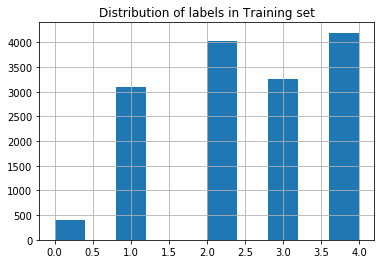

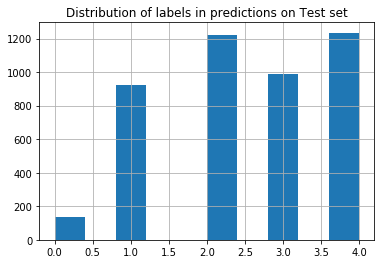

In [19]:
model_acc = np.argmax(accuracy)
print('Best number of hlayers test acc = {}'.format(model_acc+1)) 
model_sse = np.argmin(sse)
print('Best number of hlayers hist sse = {}'.format(model_sse+1)) 
s = [accuracy[i]-sse[i] for i in range(0,7)]
model = np.argmax(s)
print('Best number of hlayers total = {}'.format(model+1)) 

clf = models[model]

y_est = clf.predict(predictions)

submission = pd.DataFrame(index=X_test.index)
submission['PetID'] = id
submission['AdoptionSpeed'] = y_est
submission['AdoptionSpeed'] = submission['AdoptionSpeed'].astype(int)
submission.to_csv('submission.csv',index=False)


histy = y.hist()
plt.title('Distribution of labels in Training set')
plt.show()
plt.title('Distribution of labels in predictions on Test set')
hist2 = submission.hist()
plt.show()